### 导入运行程序，建立路网、交叉口信号灯，设置到达离去

In [1]:
from ctmnet2.simulation import Simulator
from ctmnet2.networkcreation import create_from_xml

def neta(Area="",Ver=""):
    U=[1,2,3,4]
    D=[5,6,7,8]
    sim = create_from_xml("NET-"+Area+Ver+".xml")
    sim.set_arrival(str(U[0]),1412*4)
    sim.set_departure(str(D[0]),1412*4)
    sim.set_arrival(str(U[1]),1412*3)
    sim.set_departure(str(D[1]),1412*3)
    sim.set_arrival(str(U[2]),1412*3)
    sim.set_departure(str(D[2]),1412*3)
    sim.set_arrival(str(U[3]),1412*3)
    sim.set_departure(str(D[3]),1412*3)
    return sim

### 路灯检测数据输入

In [2]:
import xml.etree.ElementTree as ET
import re

def deta(sim,Area=""):
    sec_tree=ET.parse("sec_det-"+Area+".xml")
    det_tree=ET.parse("detectors-"+Area+".xml")
    secs=sec_tree.getroot()
    dets=det_tree.getroot()
    for sec in secs.iter('section'):
        sec_id=sec.attrib['id']
        det_id=re.findall(r"\d+",sec.find('detectors').text)
        #print(sec_id,det_id)
        n=0
        for i in det_id:
            for det in dets.iter('detector'):
                if det.attrib['id']==i:
                    vol=float(det.find('volume').text)
                    sim.sections[sec_id].cells[int(n)].volume=vol
                    n=n+1
    return sim

### 开始仿真

In [3]:
def simula(sim,T=600,R='volume',S='cell'):
    result=[]
    r=[]
    s=0
    for i in range(T):
        r=[]
        s=0
        sim.run_single_step()
        if R=='volume':
            V=sim.get_volume(S)
        elif R=='density':
            V=sim.get_density(S)
        elif R=='velocity':
            V=sim.get_velocity(S)
        elif R=='occupancy':
            V=sim.get_occupancy(S)
        elif R=='delay':
            V=sim.get_delay(S)
        if S=='cell':
            for j in range(1,9):
                t=[]
                for k in range(len(V[str(j)])):
                    t.append(V[str(j)][k])
                r=r+[round(i,1) for i in t]
            result.append(r)
        elif S=='section':
            for j in range(1,9):
                s=s+V[str(j)]
            result.append(s)
    return result

### 矩阵转置并输出当前指标

In [4]:
def maTrix(matrix):
    T=[]
    tr=0
    for i in range(len(matrix[0])):
        t=[]
        for j in range(len(matrix)):
            t.append(matrix[j][i])
            tr+=matrix[j][i]
        T.append(t)
    print(tr)
    return T

### 提取路网中各路段元胞坐标

In [5]:
import xml.etree.ElementTree as ET
import re

def coora(Area=""):
    tree = ET.parse("NET-"+Area+".xml")
    root = tree.getroot()
    para = 'coordinates'
    coordinates=[]
    for sec in root.iter('section'):
        sec_id = sec.attrib['id']
        coors = re.findall(r"(\d+\.?\d*, \d+\.?\d*)",sec.find(para).text)
        COORS = []
        COOR = []
        for coor in coors:
            COOR = coor.split(',')
            COOR[0] = float(COOR[0])
            COOR[1] = float(COOR[1])
            COORS.append(COOR)
        coordinates.extend(COORS)
    return coordinates

### 仿真后生成HTML文件

In [6]:
import webbrowser
from IPython.display import IFrame

def visula(Matrix,Coor,Area="",R=""):
    with open("HMWT-"+R+"-"+Area+".html",'r',encoding='utf-8') as file:
        with open("HMWT-"+R+"-"+Area+"+.html",'w',encoding='utf-8') as out:
            load=file.read()
            p1,pr=load.split("元胞坐标")
            out.write(p1+'\n')
            for coor in Coor:
                out.write('{"lat":'+str(coor[0])+',"lng":'+str(coor[1])+'},\n')
            p2,pr=pr.split("元胞流量数据")
            out.write(p2+'\n')
            for t in Matrix:
                out.write(str(t)+',\n')
            out.write(pr)

    return IFrame(src='HMWT-'+R+"-"+Area+'+.html', width=600, height=600)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
#定义待优化函数：只能处理行向量形式的单个输入，若有矩阵形式的多个输入应当进行迭代
def CostFunction(x):
    '''x1=int(round(x[0]))
    x2=int(round(x[1]))
    x3=int(round(x[2]))
    x4=int(round(x[3]))'''
    x1=int(x[0])
    x2=int(x[1])
    x3=int(x[2])
    x4=int(x[3])
    phastr=str(x1)+' '+str(x2)+' '+str(x3)+' '+str(x4)
    global phaset
    global nss
    if phastr in phaset.keys():
        nss+=1
        return phaset[phastr]
    with open("NET-BJH.xml",'r',encoding='utf-8') as file:
        with open("NET-BJH0.xml",'w',encoding='utf-8') as out:
            load=file.read()
            p1,pr=load.split("[47, 35, 38, 28]")
            out.write(p1)
            out.write('['+str(x1)+', '+str(x2)+', '+str(x3)+', '+str(x4)+']')
            out.write(pr)
    sim=neta(Area,'0')
    sim=deta(sim,Area)
    R='delay'
    result=simula(sim,900,R,'section')
    global ns
    ns+=1
    #目标函数
    #result=sum(result)/len(result)
    result=sum(result)
    phaset[phastr]=result
    return result

In [8]:
def ABC():
    #代价函数中参数数目和范围
    nVar=4
    VarMin=25
    VarMax=50

    #蜂群算法基本参数
    iter_max=20 #最大迭代次数
    nPop=20 #单次保存的蜜源最大数量
    nOnLooker=20 #跟随峰数量
    L=np.around(0.6*nVar*nPop) #蜜源抛弃上界
    a=1 #蜜源搜索范围扩大系数

    #创建各记录矩阵
    PopPosition=np.zeros([nPop,nVar]) #蜜源位置矩阵
    PopCost=np.zeros([nPop,1]) #蜜源代价矩阵
    Probability=np.zeros([nPop,1]) #蜜源选择概率矩阵
    BestSol=np.zeros([iter_max+1,nVar]) # 历史最优蜜源矩阵
    BestCost=np.inf*np.ones([iter_max+1,1]) #历史最优蜜源位置矩阵
    Mine=np.zeros([nPop,1]) #蜜源开采量矩阵

    #初始化蜜源位置
    PopPosition=(VarMax-VarMin)*np.random.rand(nPop,nVar)+VarMin
    for i in range(nPop):
        PopPosition[i]=[int(round(p)) for p in PopPosition[i]]
        PopCost[i][0]=CostFunction(PopPosition[i])
        if PopCost[i][0]<BestCost[0][0]:
            BestCost[0][0]=PopCost[i][0]
            BestSol[0]=PopPosition[i]

    for iter in range(iter_max):
        global ns
        print(ns)

        #雇佣蜂阶段

        #寻找下一个蜜源
        for i in range(nPop):
            phi=a*np.random.rand(nVar)
            NewPosition=VarMin+phi*(VarMax-VarMin)
            NewPosition=[int(round(p)) for p in NewPosition]

            #进行贪婪选择
            NewCost=CostFunction(NewPosition)
            if NewCost<PopCost[i][0]:
                PopPosition[i]=NewPosition
                PopCost[i][0]=NewCost
            else:
                Mine[i][0]=Mine[i][0]+1

        #跟随蜂阶段

        #计算选择概率矩阵
        Mean=np.mean(PopCost)
        for i in range(nPop):
            Probability[i][0]=np.exp(-PopCost[i][0]/Mean)
        Probability=Probability/np.sum(Probability)
        CumProb=np.cumsum(Probability)

        for k in range(nOnLooker):

            #执行轮盘赌选择法
            m=0
            for i in range(nPop):
                m=m+CumProb[i]
                if m>=np.random.rand(1):
                    break

            #重复雇佣蜂操作
            phi=a*np.random.rand(nVar)
            NewPosition=VarMin+phi*(VarMax-VarMin)
            NewPosition=[int(round(p)) for p in NewPosition]

            #进行贪婪选择
            NewCost=CostFunction(NewPosition)
            if NewCost<PopCost[i][0]:
                PopPosition[i]=NewPosition
                PopCost[i][0]=NewCost
            else:
                Mine[i][0]=Mine[i][0]+1

        #侦查蜂阶段
        for i in range(nPop):
            if Mine[i][0]>=L:
                PopPosition[i]=(VarMax-VarMin)*np.random.rand(1,nVar)+VarMin
                PopPosition[i]=[int(round(p)) for p in PopPosition[i]]
                PopCost[i][0]=CostFunction(PopPosition[i])
                Mine[i][0]=0

        #保存历史最优解
        for i in range(nPop):
            if PopCost[i][0]<BestCost[iter+1][0]:
                BestCost[iter+1][0]=PopCost[i][0]
                BestSol[iter+1]=PopPosition[i]
        
    #输出结果
    y=np.zeros(iter_max+1)
    for i in range(iter_max+1):
        print(i,BestCost[i],BestSol[i])
        y[i]=BestCost[i][0]
    print(min(y),BestSol[np.argmin(y)])
    x=[i for i in range(iter_max+1)]
    plt.plot(x,y)
    plt.show()

In [9]:
Area="BJH"
R="delay"
sim=neta(Area)
sim=deta(sim,Area)
result=simula(sim,900,R)
Result=maTrix(result)
Coor=coora(Area)
visula(Result,Coor,Area,R)

9713.40000000003


20
60
100
140
180
220
260
300
341
381
422
464
504
544
584
624
665
705
745
785
0 [9433.13813479] [48. 38. 42. 41.]
1 [8190.51118147] [48. 36. 50. 42.]
2 [8190.51118147] [48. 36. 50. 42.]
3 [8190.51118147] [48. 36. 50. 42.]
4 [8190.51118147] [48. 36. 50. 42.]
5 [8190.51118147] [48. 36. 50. 42.]
6 [8190.51118147] [48. 36. 50. 42.]
7 [8190.51118147] [48. 36. 50. 42.]
8 [8072.04007856] [50. 45. 48. 32.]
9 [8072.04007856] [50. 45. 48. 32.]
10 [8072.04007856] [50. 45. 48. 32.]
11 [8072.04007856] [50. 45. 48. 32.]
12 [8072.04007856] [50. 45. 48. 32.]
13 [8072.04007856] [50. 45. 48. 32.]
14 [8072.04007856] [50. 45. 48. 32.]
15 [8072.04007856] [50. 45. 48. 32.]
16 [8072.04007856] [50. 45. 48. 32.]
17 [8072.04007856] [50. 45. 48. 32.]
18 [8072.04007856] [50. 45. 48. 32.]
19 [8072.04007856] [50. 45. 48. 32.]
20 [8072.04007856] [50. 45. 48. 32.]
8072.040078561646 [50. 45. 48. 32.]


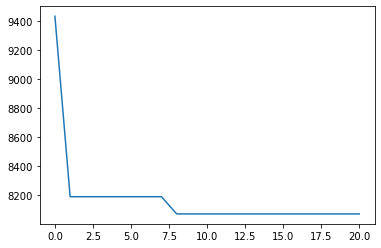

826 0
Wall time: 2min 1s


In [10]:
%%time
phaset={}
ns=0
nss=0
ABC()
print(ns,nss)

In [11]:
from collections import Counter
a=phaset.keys()
b=Counter(a)
len(b)

826